In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import tensorflow as tf

from deepsphere import HealpyGCNN
from deepsphere import healpy_layers as hp_layer
from deepsphere import utils

import os

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [27]:
def Correlation(map1, map2):
    return hp.anafast(map1,map2)/np.sqrt(hp.anafast(map1)*hp.anafast(map2))

In [4]:
model = tf.keras.models.load_model('./SavedModels/R2.81/',custom_objects={'r_square':r_square})

In [5]:
#Data
kSZFiles = os.listdir('./Data/kSZ')
velFiles = os.listdir('./Data/velocityField')
densFiles = os.listdir('./Data/overdensity')

nside = 64
numSets=len(densFiles)

overdensData = np.zeros((numSets,12*nside**2))
kSZData = np.zeros((numSets,12*nside**2))
velData = np.zeros((numSets,12*nside**2))

for i in range(0,numSets):
    overdensData[i] = hp.reorder(np.load('./Data/overdensity/'+densFiles[i]),r2n=True)
    overdensData[i] = 100*overdensData[i]/np.linalg.norm(overdensData[i])
    kSZData[i] = hp.reorder(np.load('./Data/kSZ/'+kSZFiles[i]),r2n=True)
    kSZData[i] = 100*kSZData[i]/np.linalg.norm(kSZData[i])
    velData[i] = hp.reorder(np.load('./Data/velocityField/'+velFiles[i]),r2n=True)
    velData[i] = 100*velData[i]/np.linalg.norm(velData[i])

In [6]:
x_raw = np.stack((overdensData,kSZData),axis=2)
x_raw = np.reshape(x_raw,(numSets,12*nside**2,2))

x_train, x_test = np.split(x_raw, indices_or_sections=[numSets-numSets//20])
y_train, y_test = np.split(velData, indices_or_sections=[numSets-numSets//20])

In [37]:
numComp = 20

In [38]:
recontructedMaps = model(x_train[0:numComp]).numpy()

In [39]:
reconstructedMapsComp = hp.reorder(np.reshape(recontructedMaps,(len(recontructedMaps),12*nside**2)),n2r=True)

In [62]:
y_trainComp = hp.reorder(y_train,n2r=True)
overdensDataComp = hp.reorder(overdensData,n2r=True)
kSZDataComp = hp.reorder(kSZData,n2r=True)

/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/visufunc.py:195: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = pylab.figure(fig, figsize=(8.5, 5.4))


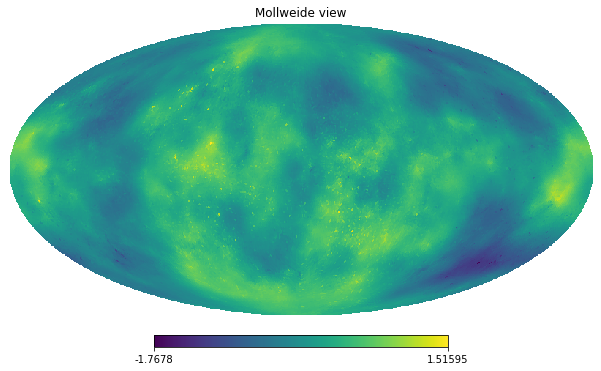

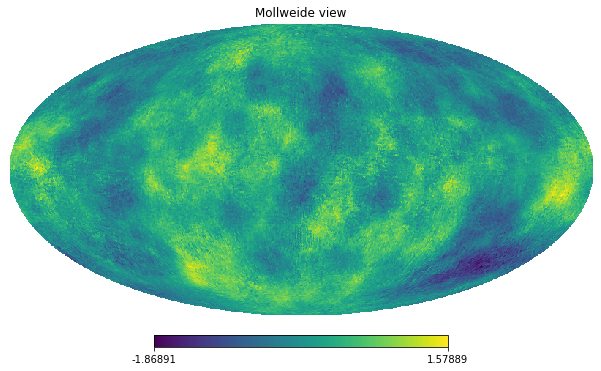

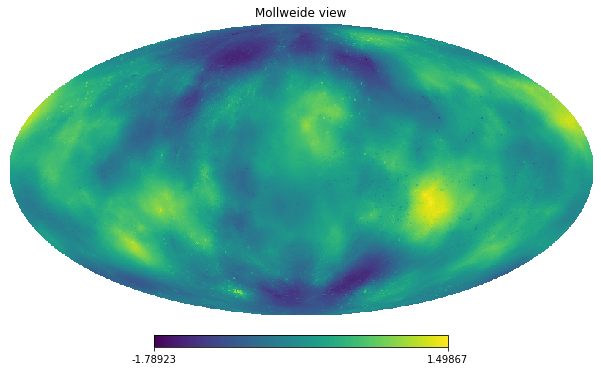

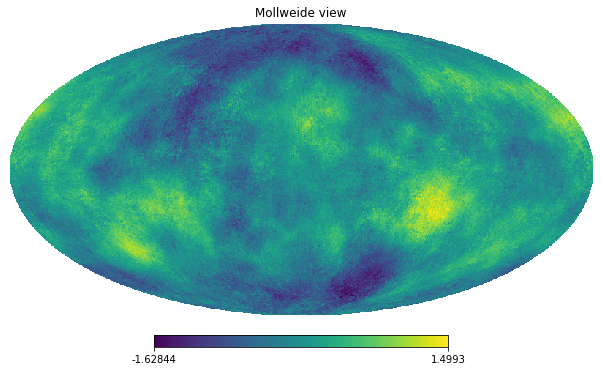

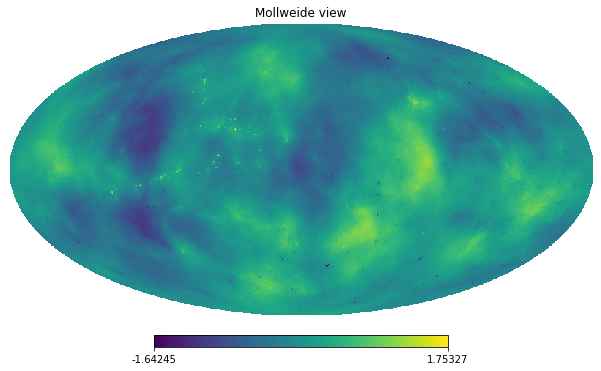

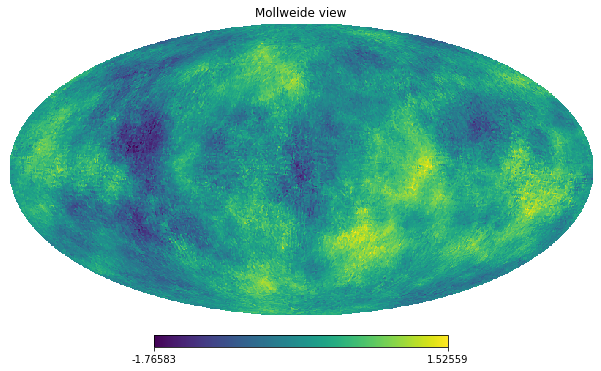

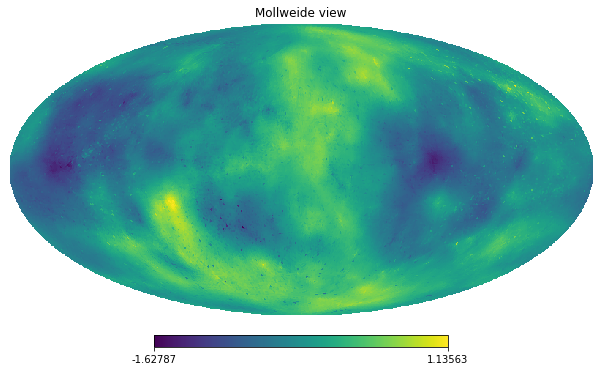

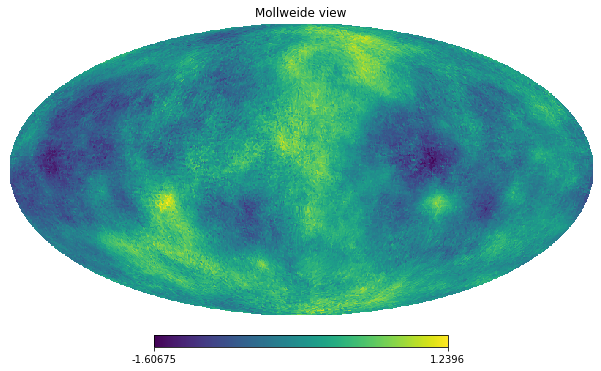

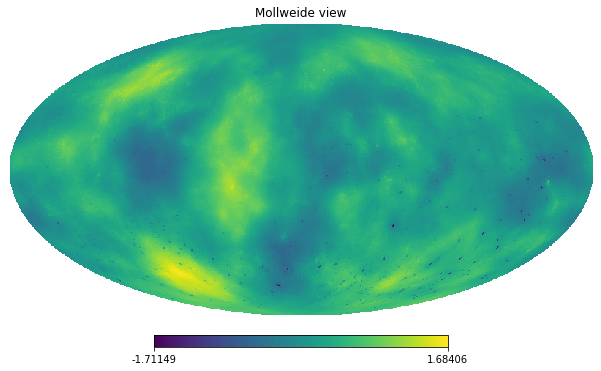

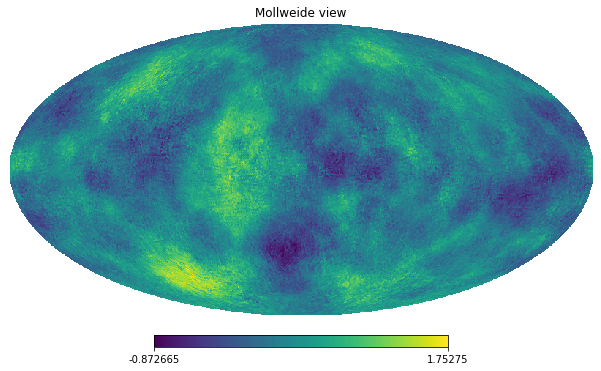

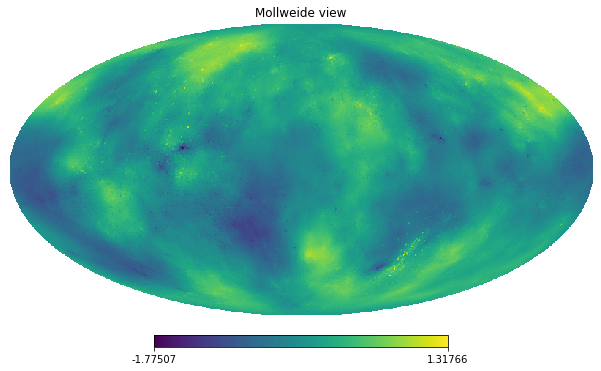

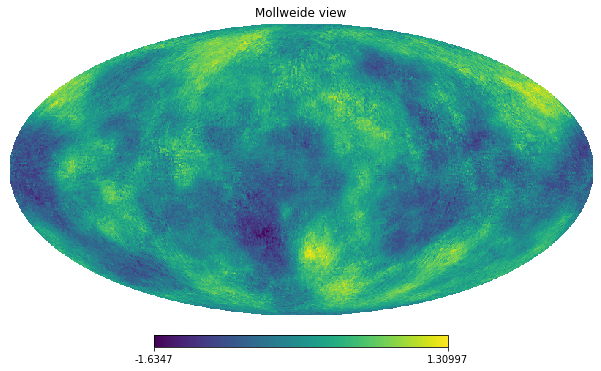

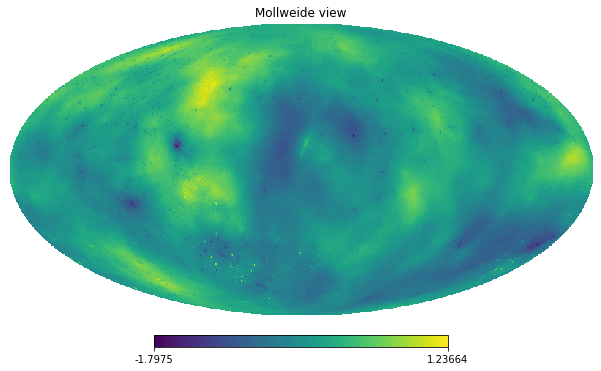

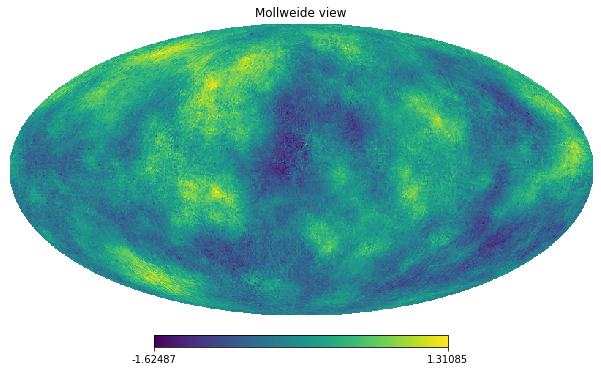

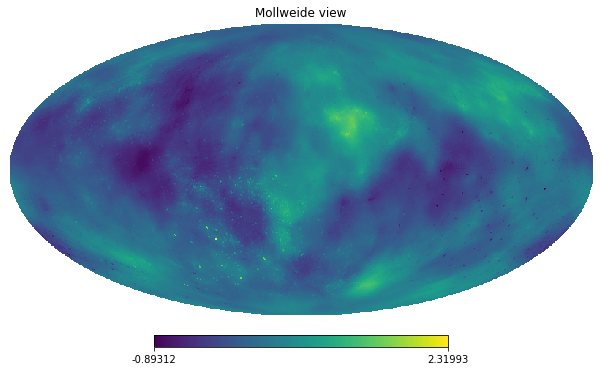

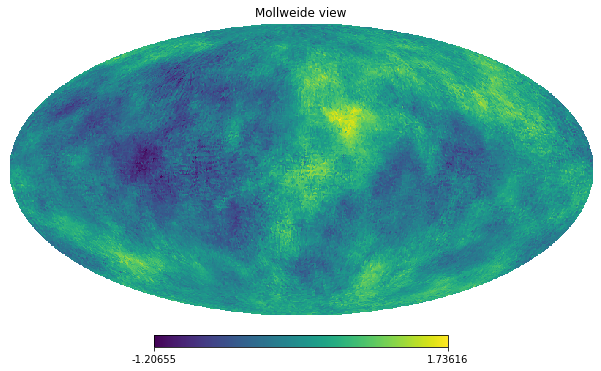

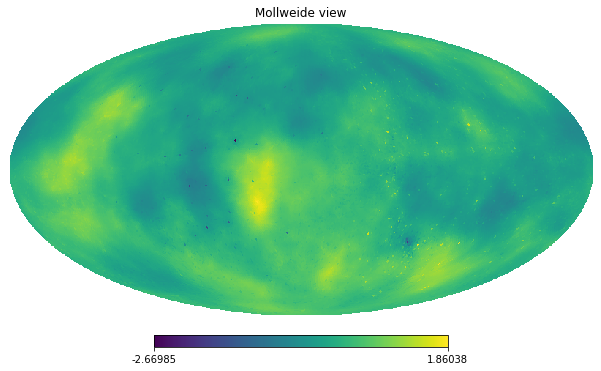

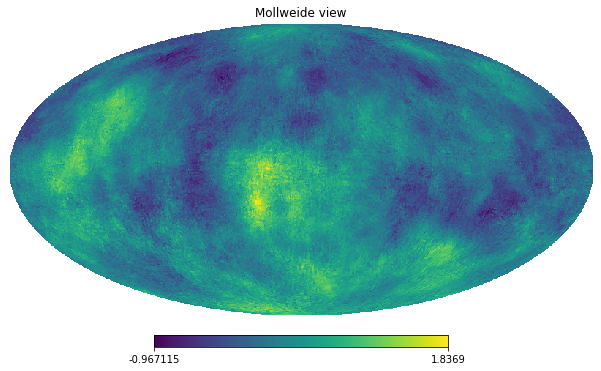

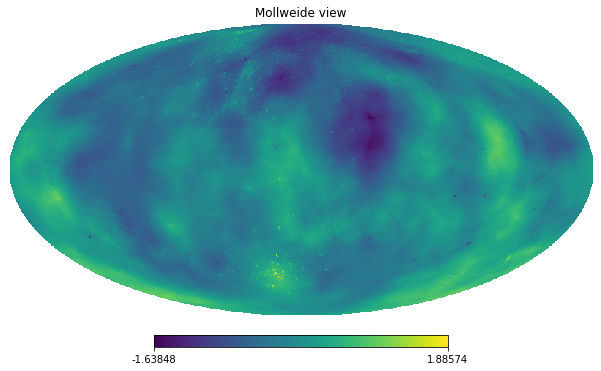

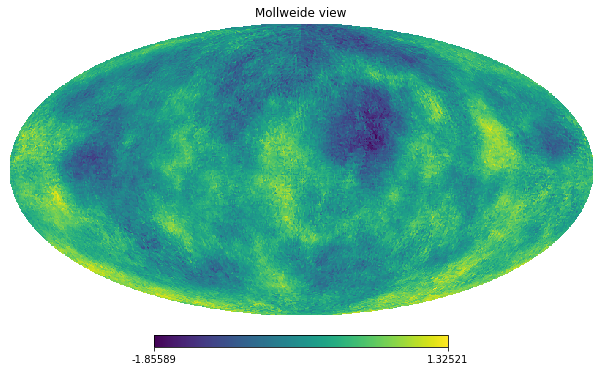

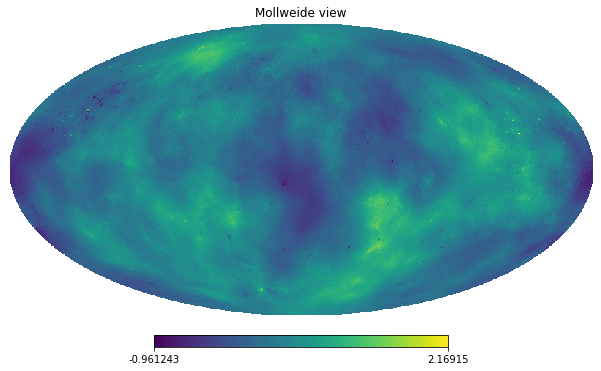

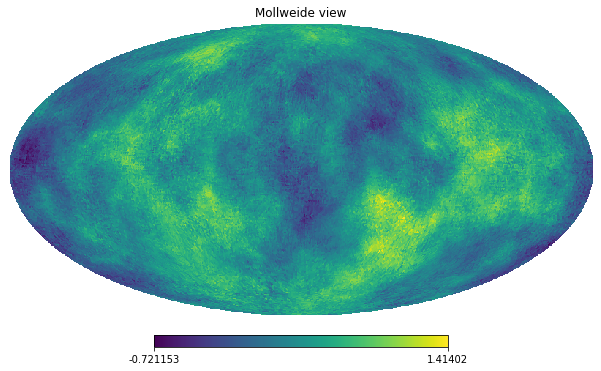

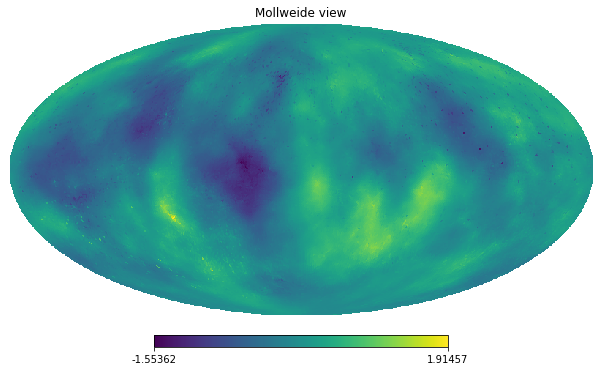

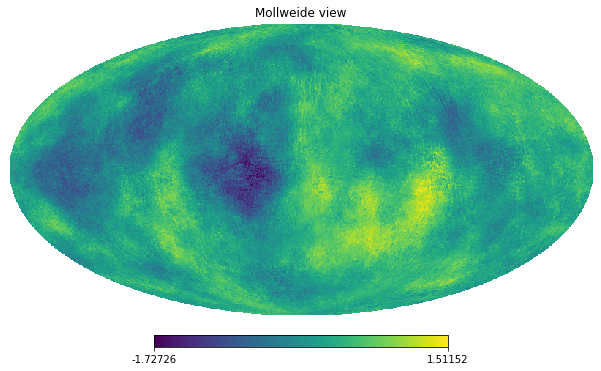

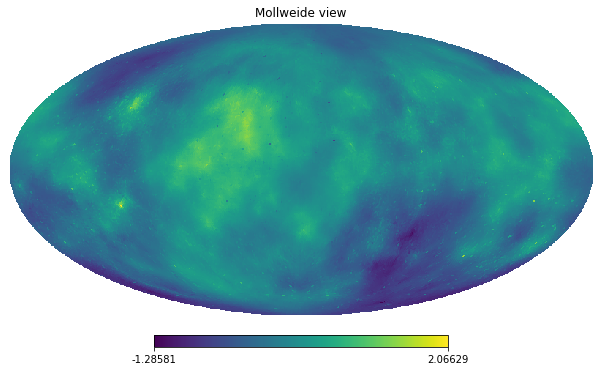

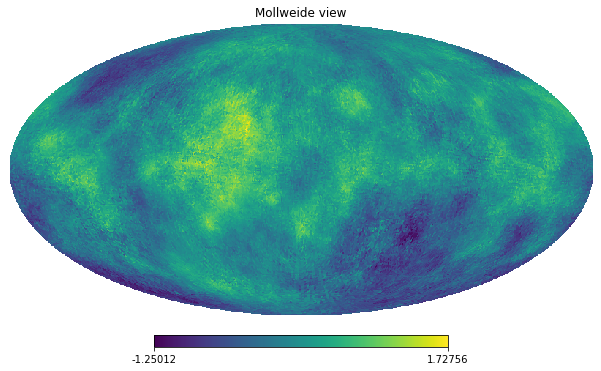

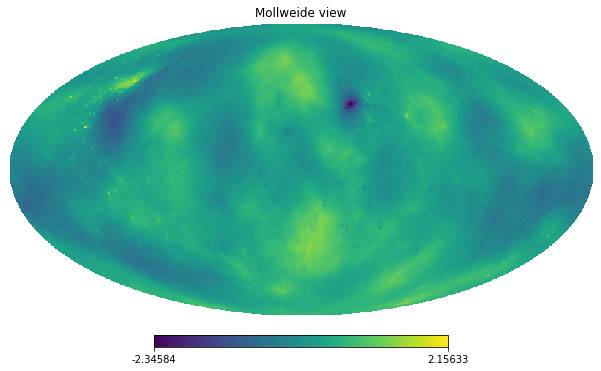

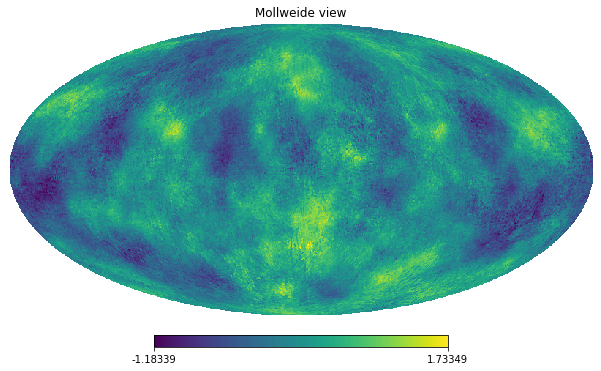

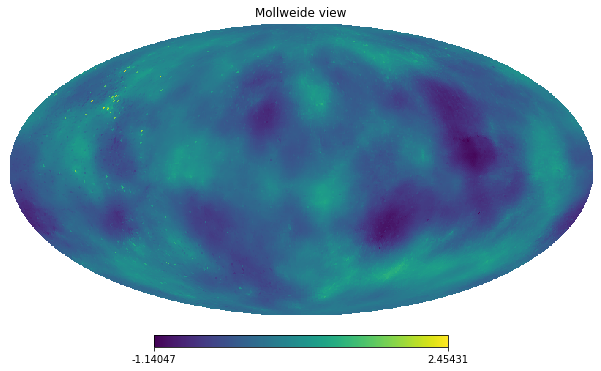

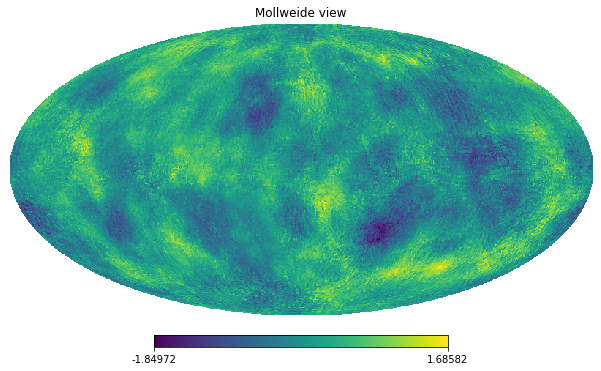

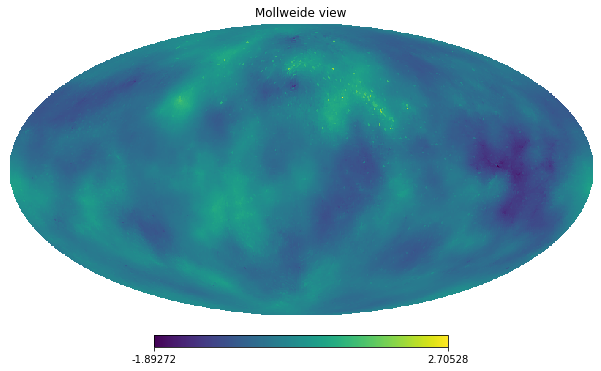

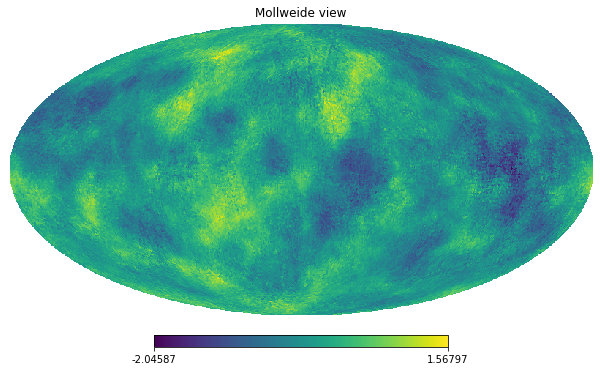

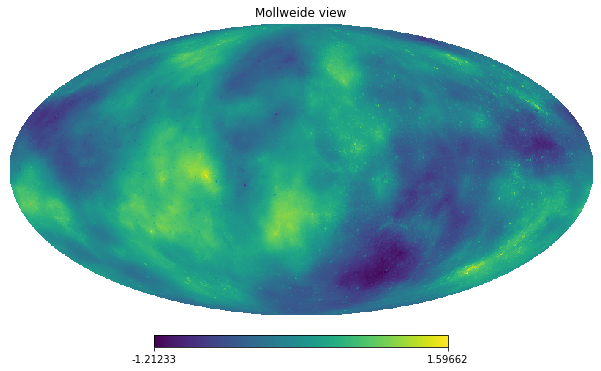

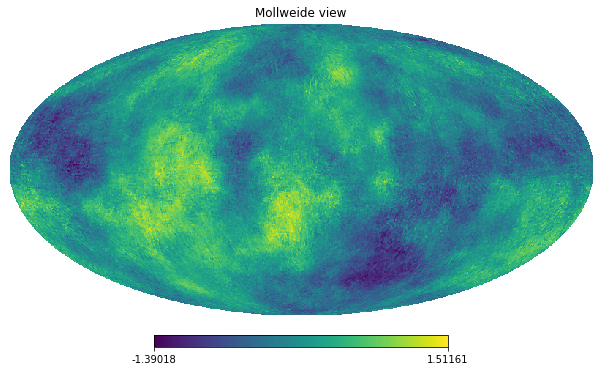

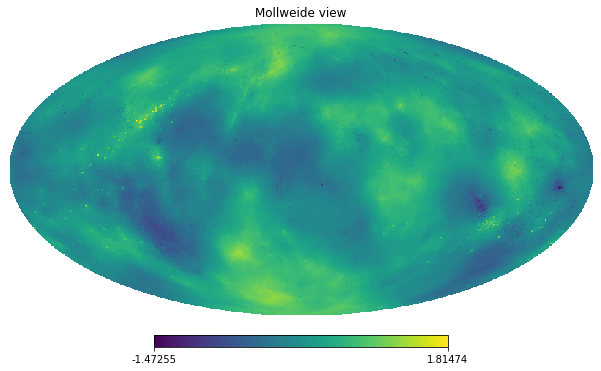

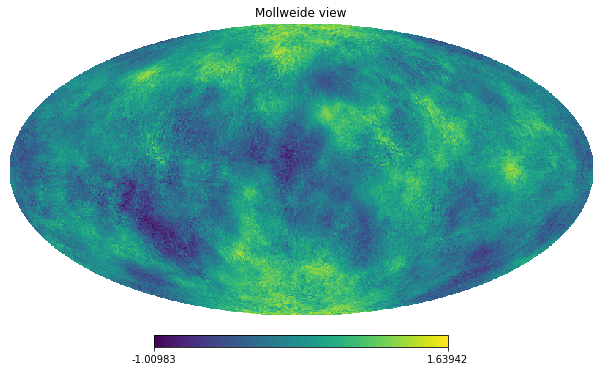

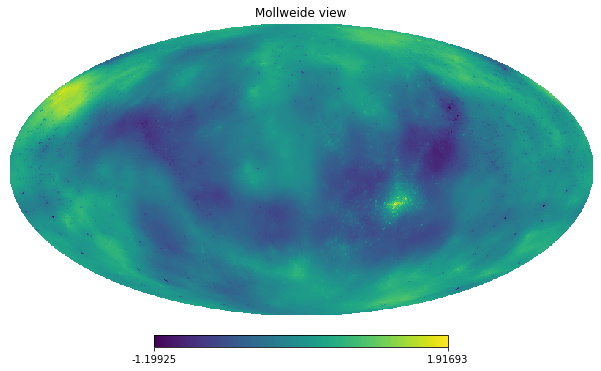

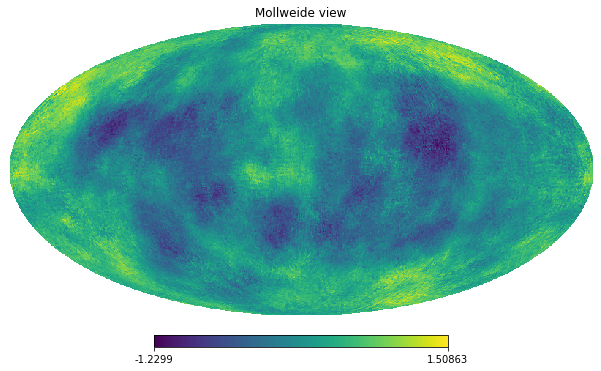

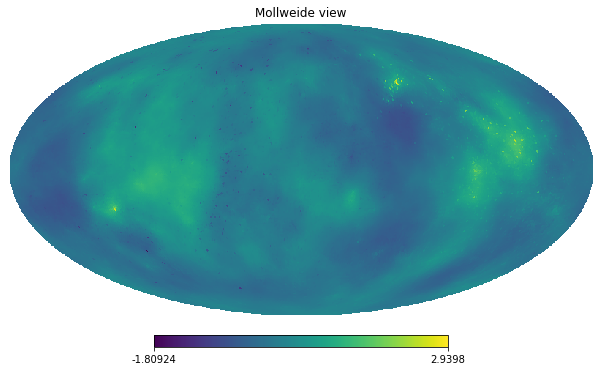

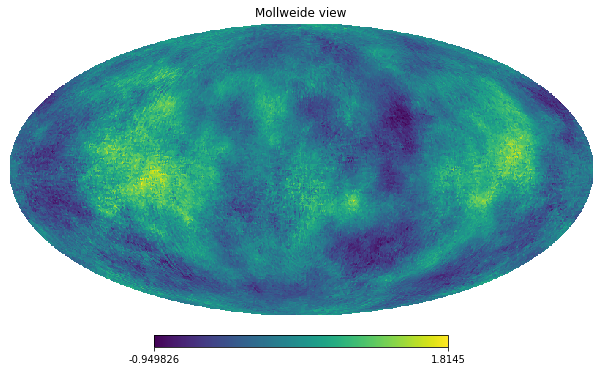

In [44]:
for i in range(0,numComp):
    hp.mollview(reconstructedMapsComp[i])
    hp.mollview(y_trainComp[i])

In [45]:
sumCorr = Correlation(reconstructedMapsComp[0],y_trainComp[0])

for i in range(1,numComp):
    sumCorr = sumCorr + Correlation(reconstructedMapsComp[i],y_trainComp[i])
    
sumCorr = sumCorr/numComp

(0.0, 1.0)

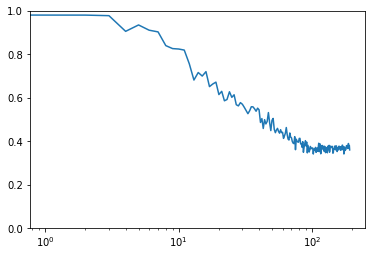

In [47]:
plt.semilogx(sumCorr)
plt.ylim([0,1])

# Quadratic Estimator

In [50]:
import camb
#import pywigxjpf as pywig
from joblib import Parallel, delayed
import sys, argparse, multiprocessing
#from common import *
from scipy.signal import savgol_filter

In [57]:
#rho map is just the overdensity
def quadEst(Obs_T_map, ksz_map, rho_map):
    
    ksz_PS = hp.anafast(ksz_map)

    #Obs_T_map = ksz_map

    ClTT = hp.anafast(ksz_PS)

    dTlm = hp.map2alm(Obs_T_map)
    dlm = hp.map2alm(rho_map)

    dTlm_resc = hp.almxfl(dTlm, 1.0/ClTT)
    dT_resc = hp.alm2map(dTlm_resc, nside)
    dlm = -1.0*dlm # dlm_resc = hp.almxfl(dlm, 1.0) #Cltd/Cldd
    d_resc = hp.alm2map(dlm, nside)

    unnorm_veff_reconstlm = hp.map2alm(dT_resc*d_resc)
    unnorm_veff_reconst_ps = hp.alm2cl(unnorm_veff_reconstlm)
    unnorm_veff_reconst = hp.alm2map(unnorm_veff_reconstlm, nside)

    return unnorm_veff_reconst

In [63]:
quadMaps = np.zeros((numComp,12*nside**2))

for i in range(numComp):
    quadMaps[i,:] = quadEst(kSZDataComp[i,:],kSZDataComp[i,:],overdensDataComp[i,:])

/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


In [67]:
sumCorrQuad = Correlation(quadMaps[0],y_trainComp[0])

for i in range(1,numComp):
    sumCorrQuad = sumCorrQuad + Correlation(quadMaps[i],y_trainComp[i])
    
sumCorrQuad = sumCorrQuad/numComp

(-0.2, 1.0)

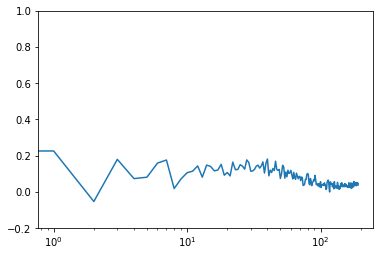

In [69]:
plt.semilogx(sumCorrQuad)
plt.ylim([-0.2,1])

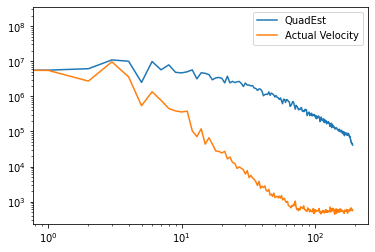

In [81]:
plt.figure()
plt.loglog(hp.anafast(quadMaps[0]))
plt.loglog(hp.anafast(y_trainComp[0]*10**4))
plt.legend(["QuadEst","Actual Velocity"]);

# Comparison

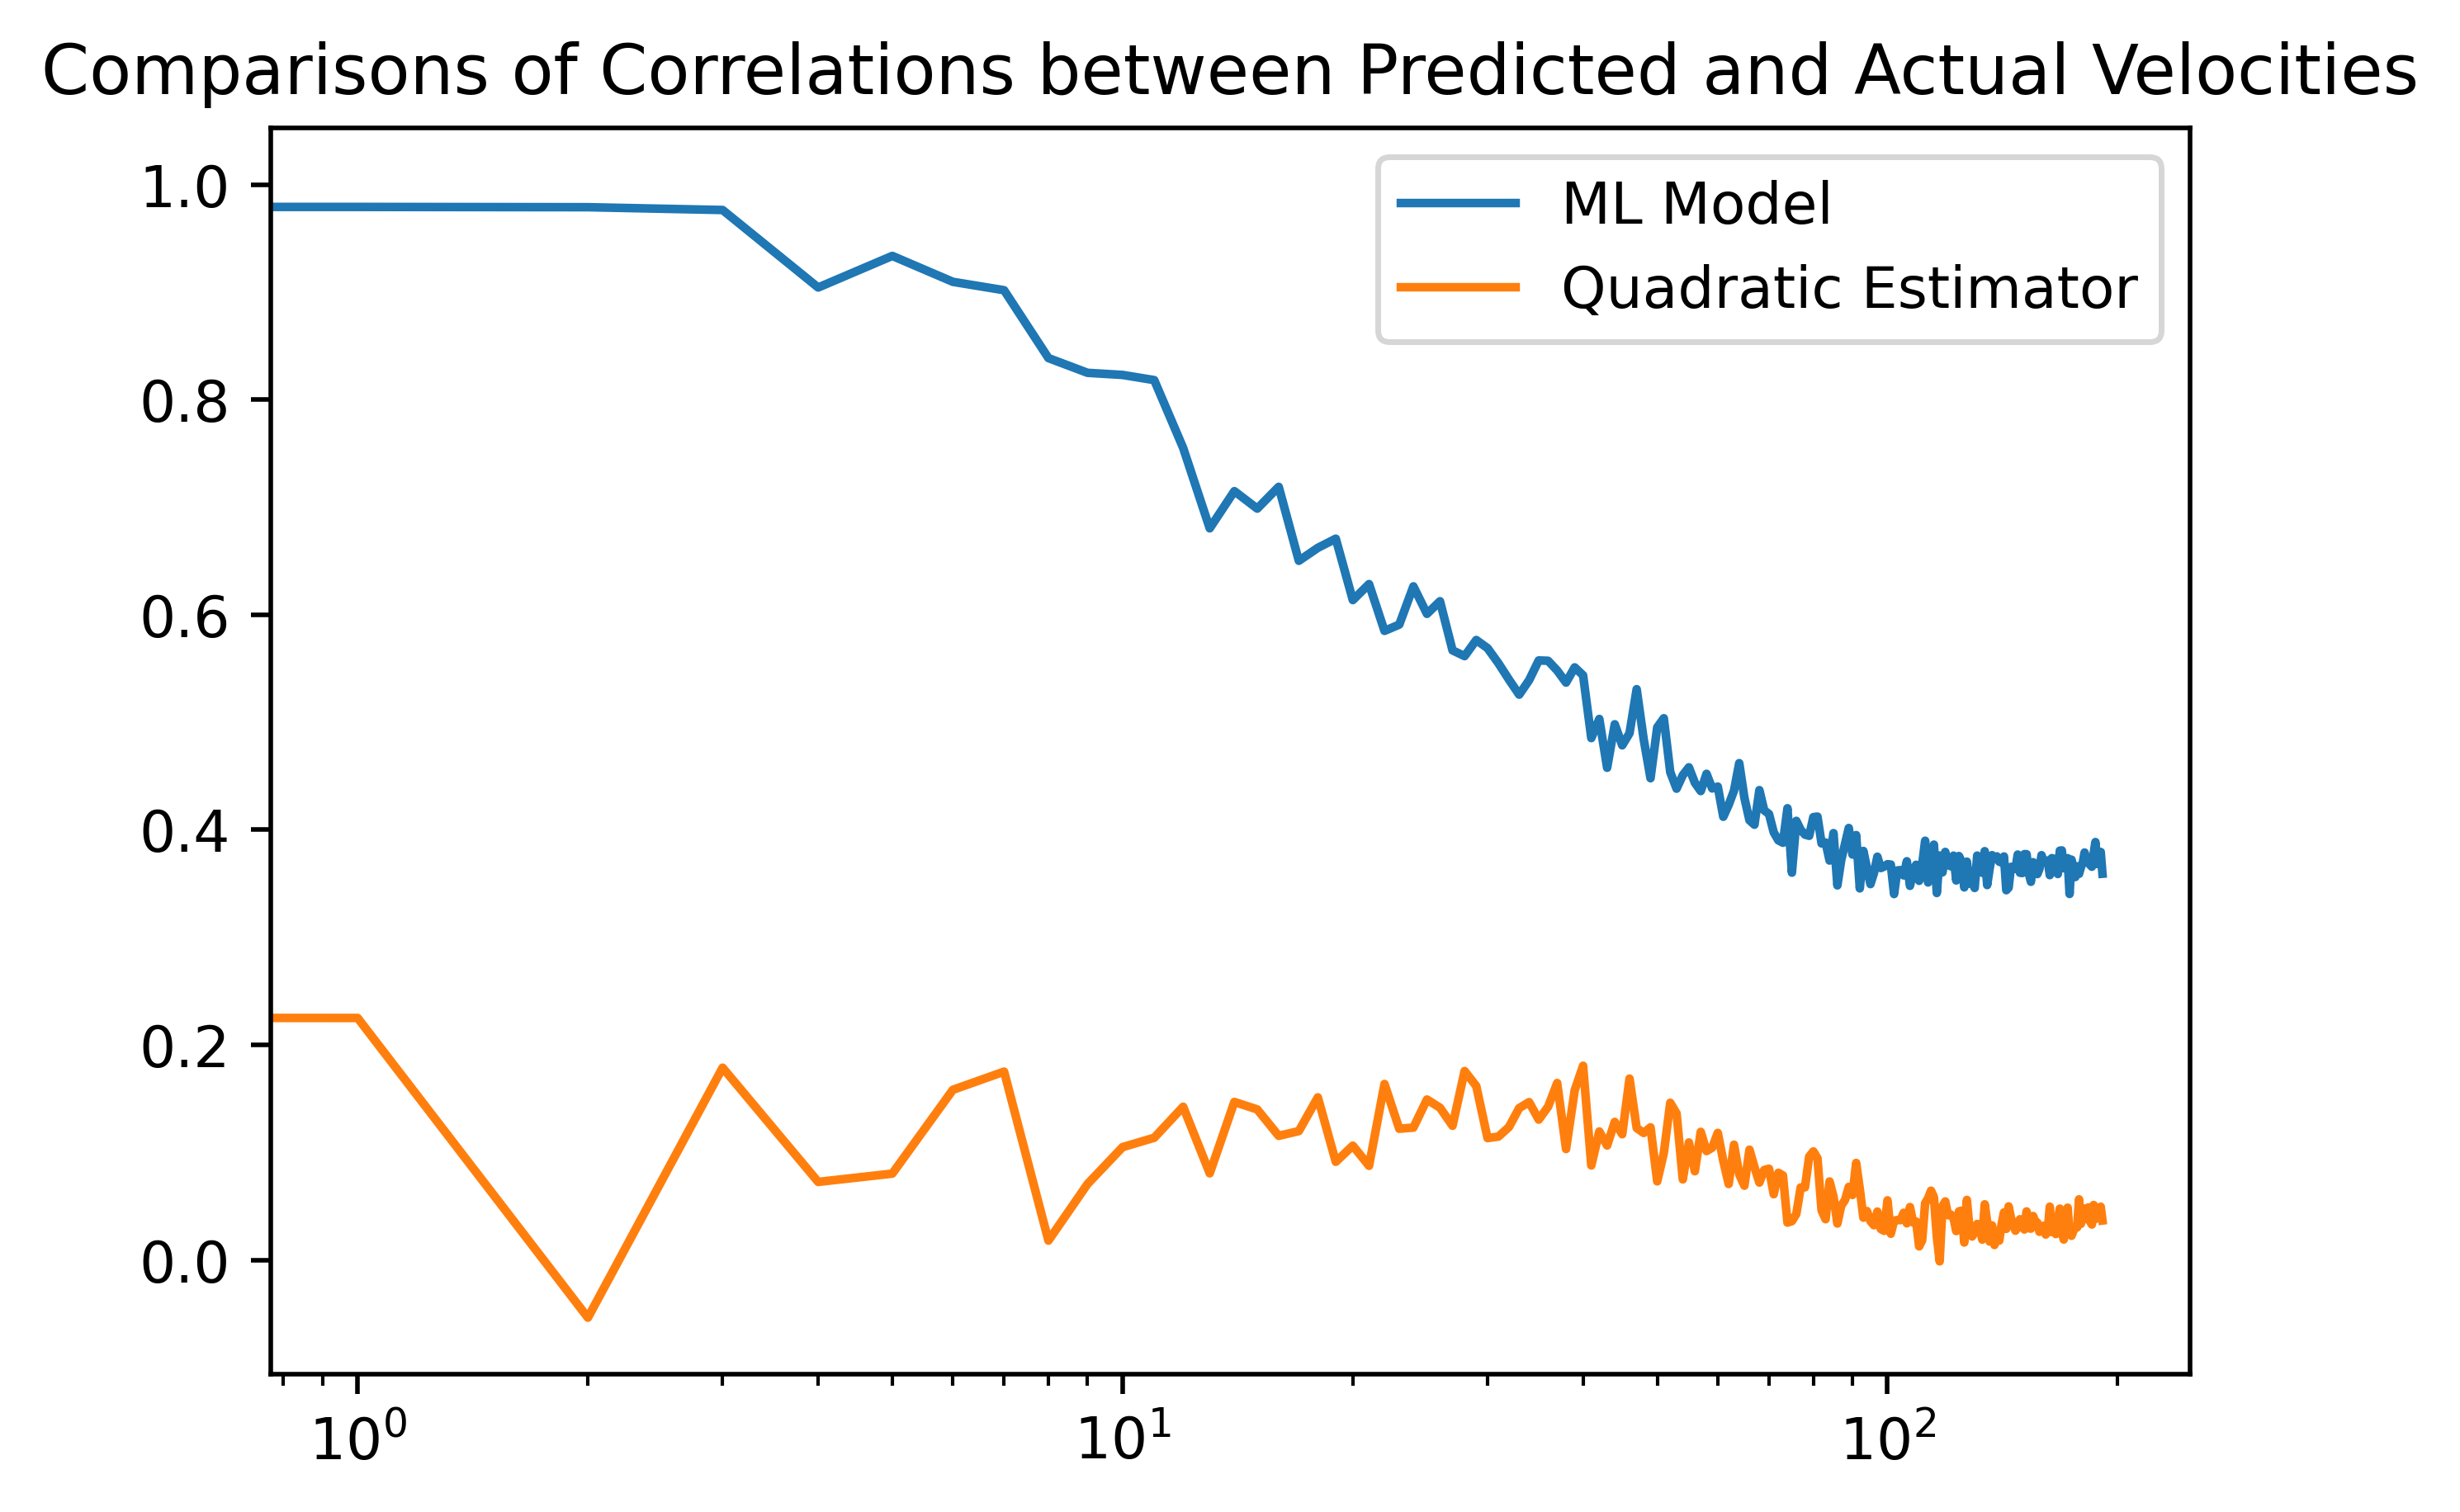

In [84]:
plt.figure(dpi=500)
plt.semilogx(sumCorr);
plt.semilogx(sumCorrQuad);
plt.legend(["ML Model","Quadratic Estimator"]);
plt.title("Comparisons of Correlations between Predicted and Actual Velocities");